# How much GPU RAM do you need and how much data fits into a GPU task?

## GPU memory size planning & data ratios for Parquet, Arrow, RAPIDS/cuDF, and Graphistry/GFQL

Put too much data into a GPU or use a GPU without enough memory and things fall apart. Whatever GPU you pick, you may then want to partition your data to make sure it fits, but make partitions too small and now you risk only getting a fraction of the available GPU speedups.

Achieving high performance with your GPUs often starts with navigating these questions.

It is surprisingly simple in practice to stay within your GPU memory budget once you understand some common data ratios that occur at basic data pipeline phases.

Using a representative activity logs dataset, we will work through a typical GPU ETL & analytics pipeline that starts all the way from disk:

* Parquet (disk, compressed): 0.1-0.5X
* Arrow (CPU, in-memory): 0.2-1X
* **Pandas (CPU, in-memory): 1X <-- baseline**
* cuDF (GPU, in-memory): 0.2-1X
* **GPU compute operations (GPU): 0.2-1X  <-- includes cuDF tabular queries and GFQL graph queries**
* Overall Peak Usage: 1-2X
* Variants: **Multi-GPU**, **multi-node**, and **AI+ML**

Even before we begin, note that the above ratios already show GPU libraries typically consume a small fraction of the memory required by popular CPU-based libraries like Pandas: They're built with better performance in mind in general, not just because of GPU processing.

# Phase 1: Setup and Data Creation

(Skip ahead to **The data** if you're just skimming)

## Installs & imports

Pandas (CPU), RAPIDS cuDF (GPU), PyGraphistry

In [9]:
! pip install -q graphistry

In [ ]:
# For freely testing on colab.research.google.com:

# RAPIDS for Google Colab
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
! git clone -q https://github.com/rapidsai/rapidsai-csp-utils.git
! python rapidsai-csp-utils/colab/pip-install.py > /dev/null 2>&1


In [11]:
import cudf
cudf.__version__

'24.10.01'

In [12]:
# Initialize RMM with a managed memory pool; this will automatically apply to cuDF allocations.
import cudf
import rmm
import rmm.statistics
rmm.reinitialize(pool_allocator=True, managed_memory=True)
rmm.statistics.enable_statistics()

# Initialize NVML for direct GPU memory measurement
import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

In [13]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import cudf
import graphistry
import matplotlib.pyplot as plt
import os
from graphistry import e, n

### The data
One million simulated network traffic connection events with timestamped events (src_ip, dst_ip) representing graph edges


In [14]:
rows = 1_000_000
data = {
    "timestamp": pd.date_range(start="2023-01-01", periods=rows, freq="S"),
    "src_ip": np.random.choice([f"192.168.1.{i}" for i in range(1, 256)], rows),
    "dst_ip": np.random.choice([f"10.0.0.{i}" for i in range(1, 256)], rows),
    "event_type": np.random.choice(["connect", "disconnect", "data_transfer"], rows),
    "bytes_transferred": np.random.randint(0, 1000, rows),
}
df = pd.DataFrame(data)
df.head()

<ipython-input-14-4e913c230e95>:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  "timestamp": pd.date_range(start="2023-01-01", periods=rows, freq="S"),


,timestamp,src_ip,dst_ip,event_type,bytes_transferred
0,2023-01-01 00:00:00,192.168.1.6,10.0.0.216,disconnect,595
1,2023-01-01 00:00:01,192.168.1.247,10.0.0.73,connect,754
2,2023-01-01 00:00:02,192.168.1.244,10.0.0.32,connect,630
3,2023-01-01 00:00:03,192.168.1.204,10.0.0.207,disconnect,348
4,2023-01-01 00:00:04,192.168.1.121,10.0.0.219,connect,710


## Phase 2: Measure space usage on-disk with Parquet and CPU in-memory with Pandas

### 4X CPU in-memory compaction with Arrow

The Apache Arrow in-memory computing table format makes analytics fast by **packing data into typed columns** (vs typical row-wise SQL, KV, graph, and log databases). A typical benefit is data also getting smaller

### 20X disk compaction with Parquet

Parquet adds **compression algorithms for each column**, giving another 5X multiple over Arrow

Both Parquet and Arrow have their place. Arrow avoids compression for in-memory use to enable faster in-memory access. Parquet prioritizes compression for better disk storage.

In [15]:
# Pandas Dataframe size
pandas_memory = df.memory_usage(index=True, deep=True).sum() / (1024**2)

# Arrow Table size
arrow_table = pa.Table.from_pandas(df)
arrow_size = arrow_table.nbytes / (1024**2)

# Parquet compressed size
pq_file_path = "compressed_data.parquet"
pq.write_table(arrow_table, pq_file_path, compression="SNAPPY")
parquet_size = os.path.getsize(pq_file_path) / (1024**2)

print(f"Pandas in-memory size: {pandas_memory:.2f} MB")
print(f"Arrow in-memory size: {arrow_size:.2f} MB")
print(f"Parquet compressed size on disk: {parquet_size:.2f} MB")


Pandas in-memory size: 209.00 MB
Arrow in-memory size: 57.36 MB
Parquet compressed size on disk: 9.57 MB


## Phase 3: Load data into the GPU with cuDF and PyGraphistry

### 4X GPU compaction with cuDF

`cuDF` is an open source GPU-based dataframe library that matches the Pandas API. Note that cuDF is Arrow-native, so the estimated GPU memory consumption exactly matches Apache Arrow. It maintains the 4X improvement over Pandas even without doing any compute.

### 4X GPU compaction with PyGraphistry

Graph users can automate transfering a graph's tables to the GPU via [g2 = g1.to_cudf()](https://pygraphistry.readthedocs.io/en/latest/api/compute.html#graphistry.compute.ComputeMixin.ComputeMixin.to_cudf), reaping the same benefits over a Pandas-based approach.

In [16]:
# Convert DataFrame to cuDF for operations
gdf = cudf.from_pandas(df)

# Calculate the size of the gdf in memory
gdf_size_bytes = gdf.memory_usage(deep=True).sum()
gdf_size_mb = gdf_size_bytes / (1024**2)  # Convert bytes to MB
print(f"Total gdf size in memory: {gdf_size_mb:.2f} MB")

Total gdf size in memory: 57.36 MB



### Pack in 10X+ more data for real workloads with GPU projections and higher CPU RAM

It is convenient to move the entire dataframe to the GPU when there is a lot of room, so we recommend doing that during prototyping.

However, 10X+ bigger workloads can often be easily handled on the same GPU just by mindful of which columns to use at the beginning:

```python
    # Only transfer 2 columns from df to the GPU
    df2 = cudf.from_pandas(df[['src_ip', 'dst_ip']])
```

CPU RAM is often cheaper than GPU RAM, so you may want your CPU to have 1-4X more RAM than your GPUs

### Off-GPU IO Speeds

To handle bigger-than-memory datasets, it helps to keep in mind that data travels through different speed devices as it goes through disk to GPU:

It helps to pair your GPU RAM with even more (cheaper) CPU RAM or disk:
* Individual SSDs can do 1-5 GB/s, and arrays of them can do 100GB+/s
* Consumer speeds for disk->CPU and CPU->GPU are around 32 GB/s per 1-2 GPUs via PCIe 4.0
* Server-grade are often PCIe 5.0 at 64 GB/s per 1-2 GPUs

For advanced setups, such as for going at 100 GB/s on 1-2 GPUs, see our recorded Dask Summit talk on [100GB/s GPU Log Analytics at Graphistry](https://www.youtube.com/watch?v=8ZMzsTbfImU). It reviews broad concepts, architecture, and tricks like skipping the convoluted CPU path via [GPU Direct](https://developer.nvidia.com/gpudirect).


## Phase 4: GPU Computation - Simple Task and GFQL Traversal

CPU and GPU programs need extra memory on top of the input data structure memory in order to create intermediate data structures. This is often 1-5X the input data size.

### Step A: Simple GPU computation for memory baseline

We see simple `cuDF` dataframe methods like filtering and joining are optimized, so both take < 1X the original input size. Later, however, we will see peek is multiples higher.

In [20]:
# Synchronize to ensure a clean memory state before starting
cudf.cuda.current_context().synchronize()

with rmm.statistics.profiler(name="Filter and Sum Operation"):
    filtered = gdf[gdf["event_type"] == "data_transfer"]
    total_bytes = filtered["bytes_transferred"].sum()

subset_gdf = gdf.head(10000)  # Smaller subset to avoid large memory requirements
with rmm.statistics.profiler(name="Join Operation on Subset"):
    joined = subset_gdf.merge(subset_gdf, on="src_ip", how="inner")


filter_sum_stats = rmm.statistics.default_profiler_records.records["Filter and Sum Operation"]
filter_sum_peak_mb = filter_sum_stats.memory_peak / (1024**2)
print(f"Filter & Sum Operation Memory Peak: {filter_sum_peak_mb: .2f} MB")

join_stats = rmm.statistics.default_profiler_records.records["Join Operation on Subset"]
join_peak_mb = join_stats.memory_peak / (1024**2)
print(f"Join Operation on Subset Memory Peak: {join_peak_mb: .2f} MB")

Filter & Sum Operation Memory Peak:  31.16 MB
Join Operation on Subset Memory Peak:  47.92 MB


### Step B: GPU Graph analytics with GFQL - 2-hop Traversal

The example below is a 2-hop traversal in PyGraphistry's GFQL in `cuDF` GPU engine mode, including filtering for "data_transfer" events and >500 bytes

Graph queries are more like a sequence of database operators, so unsurprisingly, so we see not only the speed benefits of `cuDF` but the memory benefits too. The memory is essentially the sum of the optimized operators used.



In [21]:
# Step 4: Profile the GFQL 2-hop Traversal
g1 = graphistry.edges(gdf, 'src_ip', 'dst_ip')  # Example edge specification for Graphistry
with rmm.statistics.profiler(name="GFQL 2-hop Traversal"):
    g2 = g1.chain([
        n(),
        e(edge_match={'event_type': 'data_transfer'},
          edge_query="bytes_transferred > 500"),
        n()
    ])

gfql_stats = rmm.statistics.default_profiler_records.records["GFQL 2-hop Traversal"]
gfql_peak_mb = gfql_stats.memory_peak / (1024**2)
print(f"GFQL 2-hop Traversal Memory Peak: {gfql_peak_mb: .2f} MB")

GFQL 2-hop Traversal Memory Peak:  80.58 MB


## Comparison chart

Let's put it all together to see each phase side by side: dataset sizes, and extra intermediate memory

Fascinatingly, the GPU version was able to do both store the data and and compute on it while taking less memory than the Pandas needed to just make the initial data structure without yet doing anything on top

In a large-scale production scenario, we would likely aim for another 10X+ by being targeted on which columns to put on the GPU and when to retire intermediate structures

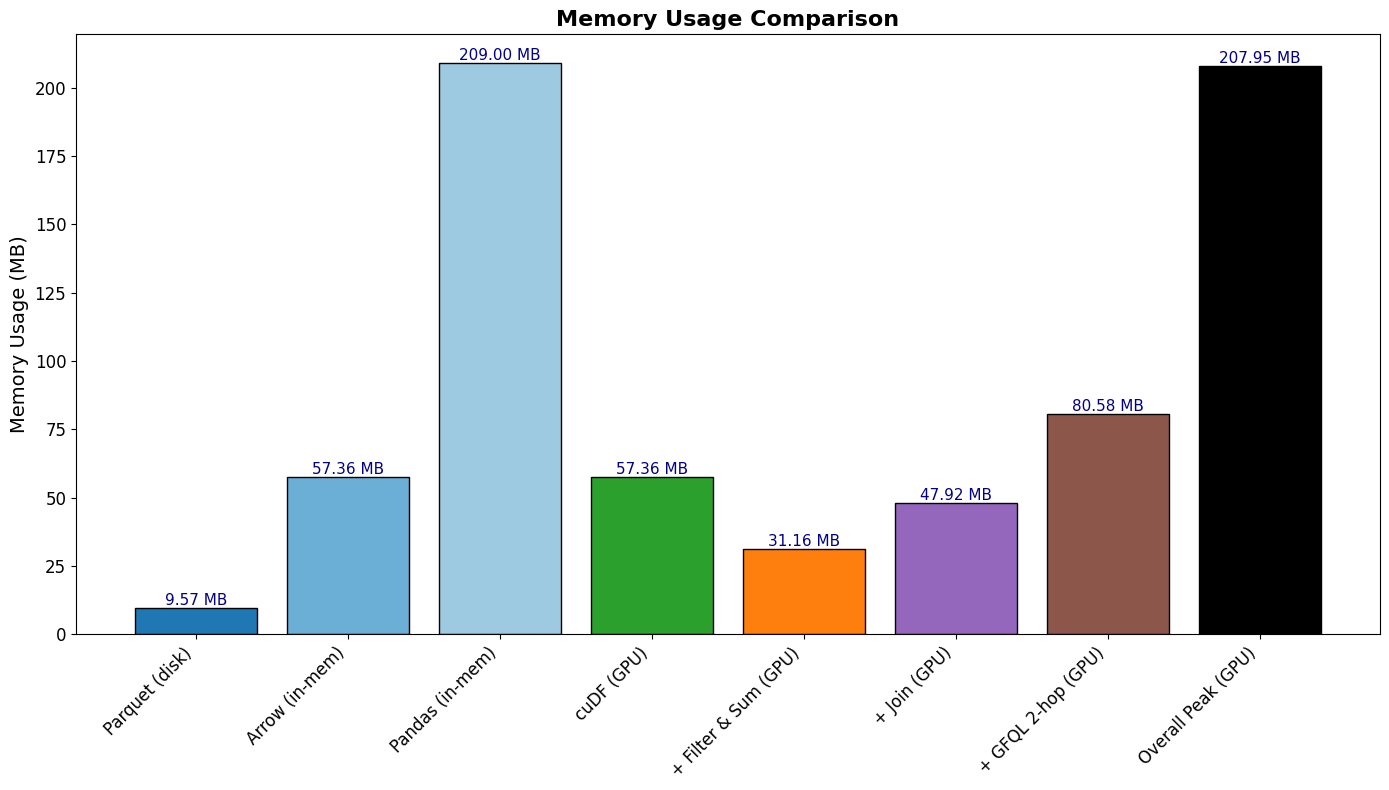

In [23]:
import matplotlib.pyplot as plt


# Labels and sizes for the bar chart
labels = [
    'Parquet (disk)',
    'Arrow (in-mem)',
    'Pandas (in-mem)',
    'cuDF (GPU)',
    '+ Filter & Sum (GPU)',
    '+ Join (GPU)',
    '+ GFQL 2-hop (GPU)',
    'Overall Peak (GPU)'
]
sizes = [
    parquet_size,
    arrow_size,
    pandas_memory,
    gdf_size_mb,
    filter_sum_peak_mb,
    join_peak_mb,
    gfql_peak_mb,
    overall_peak_mb
]

colors = ['#1f77b4', '#6baed6', '#9ecae1', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#000000']

plt.figure(figsize=(14, 8))
bars = plt.bar(labels, sizes, color=colors, edgecolor='black')

# Add labels and title with a modern font size
plt.ylabel('Memory Usage (MB)', fontsize=14)
plt.title('Memory Usage Comparison', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate and size labels for readability
plt.yticks(fontsize=12)  # Increase y-axis label font size for consistency
plt.tight_layout()

# Add value labels on top of each bar with a cleaner font style
for bar, size in zip(bars, sizes):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{size:.2f} MB',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='medium',
        color='darkblue'  # Softer label color for contrast
    )

# Display the plot
plt.show()


## Takeaways, multi-GPU/multi-node, and ML+AI

The chart reveals several key understandings:

### Parquet is a great on-disk format

It is great at compressing big tables, taking a fraction of the in-memory dataset representations

### The RAPIDS (cuDF) is a great in-memory format

Its initial GPU memory allocation sizes matches the Apache Arrow CPU in-memory size

### Memory consumption is a multiple over the input data siz

Computing takes extra space. 1X-5X additional GPU RAM was needed to compute on the dataframe than just storing it.

### Single-GPU

We recommend assuming 10X+ in-memory size needed than the size of compressed Parquet on disk

### Multi-GPU, bigger-than-memory, & dask-cudf

When manually chunking big datasets, such as for bigger-than-memory compute or spreading data across multiple GPUs, or automatically via Dask, we generally recommend 1GB+ chunks. This is~10X bigger than CPU Dask tasks because GPUs are more throughput-oriented in general.  You can see our Dask Distributed Summit talk on [100GB/s GPU Log Analytics at Graphistry](https://www.youtube.com/watch?v=8ZMzsTbfImU) for more methodology here

### AI/ML Workloads

Modern data science libraries like PyGraphistry's [g.umap()](https://pygraphistry.readthedocs.io/en/latest/gfql/combo.html#umap-fit-transform-for-scaling) use GPUs and learning to scale:

#### Training

Often called `fit()`, GPU systems can often make AI/ML training phases handle 10X more data within your time budgets. As you generally do not train on all your data, this means a 10X+ bigger sample set for a higher-fidelity and more representative model.

#### Inferencing

Often called `transform()`, inference applies a trained model to the rest of your data. This is more scalable than fitting your entire data, so a massive speedup. With GPUs, this goes faster too, essentially matching your GPU budget.



## Next steps

We're preparing follow-on articles on more performance intuitions in general and deeper on the technologies discussed here, including how to more carefully measure your own workloads

Meanwhile, you may find these useful as well:

* [100GB/s GPU Log Analytics at Graphistry](https://www.youtube.com/watch?v=8ZMzsTbfImU) recorded talk at Dask Distributed Summit
* [PyGraphistry](https://pygraphistry.readthedocs.io/en/latest/10min.html) GPU-accelerated visual graph analytics
* [PyGraphistry GPU umap()](https://pygraphistry.readthedocs.io/en/latest/gfql/combo.html#umap-fit-transform-for-scaling) for visual graph AI
* The open source [GFQL dataframe-native graph query language](https://pygraphistry.readthedocs.io/en/latest/gfql/index.html) with optional GPU mode
* Try for yourself at [Graphistry Hub](https://www.graphistry.com/get-started)

